Here I will try and prove that my model isn't working. First, I will run my optimizer 3 times to see if I get different results.

Now I will compare how the mode matching compares to actually tracing the particle. I will also inspect these swarms to see that they make sense.




In [20]:
from latticeOptimizer import LatticeOptimizer
import dill
import matplotlib.pyplot as plt
from ParticleClass import Swarm,Particle
from ParticleTracerLatticeClass import ParticleTracerLattice
import numpy as np
import time
from SwarmTracerClass import SwarmTracer
from optimizerHelperFunctions import generate_Ring_And_Injector_Lattice

# ----------Solution-----------
# injector element spacing optimum configuration: nan
# storage ring tuned params 1 optimum configuration: [0.01074743 0.01867891 0.01761212 0.01024843 0.18664755]
# storage ring tuned params 2 optimum configuration: [0.64475991 0.60149558]
# cost: 0.92668415120023
# percent max flux multiplication: 7.3315848799770045
# scipy message: Optimization terminated successfully.



# ----------Solution-----------
# injector element spacing optimum configuration: nan
# storage ring tuned params 1 optimum configuration: [0.01002868 0.01852266 0.01876837 0.00984218 0.1864913 ]
# storage ring tuned params 2 optimum configuration: [0.3370546  0.68263976]
# cost: 0.6129659036716784
# percent max flux multiplication: 38.70340963283216
# scipy message: Optimization terminated successfully.
# ----------------------------

X=np.array([0.02144103, 0.03172555, 0.01353121, 0.00948905, 0.4       ])


tuning=None
PTL_Ring,PTL_Injector=generate_Ring_And_Injector_Lattice(X,tuning)

# XSpacing=[0.64475991 ,0.60149558]
# XLatticeSpace= XSpacing[:2]
# XInjectorSpace= XSpacing[2:]



optimizer=LatticeOptimizer(PTL_Ring,PTL_Injector)
optimizer.numParticlesFullSwarm=1000
# optimizer.numParticlesRing=50000
# optimizer.numParticlesInjector=1000
elementIndices=(0,6)
ringTuningBounds = [(0.0, 1.5)]*2
injectorTuningBounds = [(.01, .4), (.01, .4)]
# optimizer.catch_Optimizer_Errors(ringTuningBounds, elementIndices, tuning,'all')
# optimizer.initialize_Optimizer(elementIndices,tuning,'all',ringTuningBounds,injectorTuningBounds)
# optimizer.update_Ring_Lattice(XLatticeSpace)
# optimizer.update_Injector_Lattice(XInjectorSpace)


In [21]:
# %matplotlib tk
# optimizer.show_Floor_Plan(XSpacing)
# optimizer.floor_Plan_Cost(XSpacing)

In [22]:
#trace through injector
# %matplotlib tk
# %matplotlib inline
fastMode=False
h=5e-6
optimizer.generate_Swarms()
swarm=optimizer.swarmInjectorInitial
swarmInjectorTraced = optimizer.swarmTracerInjector.trace_Swarm_Through_Lattice(
    swarm
    , h, 1.0, parallel=False,
    fastMode=fastMode, copySwarm=True,
    accelerated=True,energyCorrection=False,stepsBetweenLogging=4)
swarmEnd = optimizer.move_Survived_Particles_In_Injector_Swarm_To_Origin(swarmInjectorTraced, copyParticles=True)
# print(swarmEnd.num_Particles())
swarmRingInitial = optimizer.swarmTracerRing.move_Swarm_To_Combiner_Output(swarmEnd, copySwarm=False,scoot=True)
# optimizer.latticeInjector.show_Lattice(swarm=swarmInjectorTraced,trueAspectRatio=False,showTraceLines=True,traceLineAlpha=.25,showMarkers=True,finalCoords=True,showRelativeSurvival=False) #careful about which swarm
# optimizer.swarmInjectorInitial.num_Particles(weighted=True),swarmRingInitial.num_Particles(weighted=True)

In [23]:
# %matplotlib tk
# optimizer.show_Floor_Plan(XSpacing)
# %matplotlib inline

In [24]:
#trace through lattice
%matplotlib tk
import multiprocess as mp
def params(T,energyCons=True):
    fastMode=True
    optimizer.T=T
    swarmTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmRingInitial, optimizer.h, optimizer.T, parallel=False,
                                                            fastMode=fastMode, accelerated=True, copySwarm=True,energyCorrection=energyCons,stepsBetweenLogging=4)
    # PTL_Ring.show_Lattice(swarm=swarmTraced,showMarkers=True,showTraceLines=True,traceLineAlpha=.5)
    # print(swarmTraced.lattice_Flux())
    # print(sum([p.probability*p.revolutions for p in swarmTraced]))
    survivalFrac=swarmTraced.num_Particles(weighted=True)/optimizer.swarmInjectorInitial.num_Particles(weighted=True)
    maxFluxMult=T*optimizer.latticeRing.v0Nominal/optimizer.latticeRing.totalLength
    swarmFluxMult=swarmTraced.weighted_Flux_Multiplication()
    return survivalFrac*swarmFluxMult/maxFluxMult

# TArr=np.logspace(np.log10(10.0/200.0),np.log10(100.0),30)
# with mp.Pool(10) as pool:
#     results=1e2*np.asarray(pool.map(params,TArr,chunksize=1))
params(10.0,energyCons=False)

0.28018246323294277

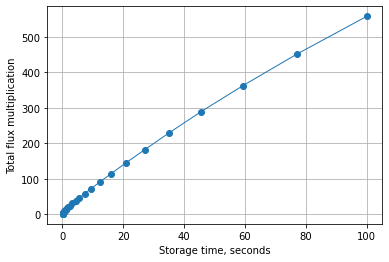

In [19]:
%matplotlib inline
resultsFluxMult=1e-2*results*TArr*optimizer.latticeRing.v0Nominal/optimizer.latticeRing.totalLength
# resultsFluxMult=resultsFluxMult/(results*1e-2)
# plt.figure(figsize=(13,8))
plt.plot(TArr,resultsFluxMult,linewidth=1.0,marker='o')
plt.grid()
plt.xlabel('Storage time, seconds')
plt.ylabel('Total flux multiplication')
# plt.savefig('image.jpg')
plt.show()

In [15]:
flux=results[:,0]
fluxMax=results[:,1]
vacuumLine=(TArr*flux[0]/TArr[0])
maxLIne=(TArr*fluxMax[0]/TArr[0])
plt.scatter(TArr,flux/fluxMax)
plt.show()
plt.scatter(TArr,flux,label='simulation results')
plt.plot(TArr,vacuumLine,label='vacuum limited injected',c='r')
plt.plot(TArr,maxLIne,label='vacuum limited, ideal loading',c='g')
plt.ylabel('Flux multiplication')
plt.xlabel('Time, seconds')
plt.grid()
plt.legend()
plt.show()
flux[-1],fluxMax[0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# look at energy conservation

In [41]:
swarmETest=Swarm()
swarmETest.particles=swarmRingInitial.particles[:11]
swarmETest.particles=[swarmRingInitial.particles[5]]
def trace_ETest_Swarm(T):
    optimizer.T=T
    swarmTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmETest, optimizer.h, optimizer.T, parallel=False,
                                                                    fastMode=False, accelerated=True, copySwarm=True,energyCorrection=True)
    return swarmTraced
t=time.time()
swarmTraced=trace_ETest_Swarm(10.0)
print(time.time()-t)

114.5606300830841


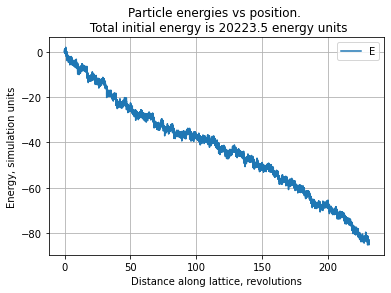

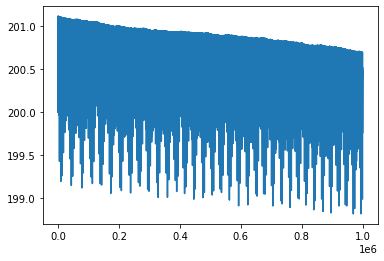

In [40]:
%matplotlib inline
# for particle in swarmTraced:
#     particle.plot_Energies()
swarmTraced.particles[0].plot_Energies(showOnlyTotalEnergy=True)
swarmTraced.particles[0].revolutions
p0Arr=swarmTraced.particles[0].p0Arr
plt.plot(p0Arr)
plt.show()

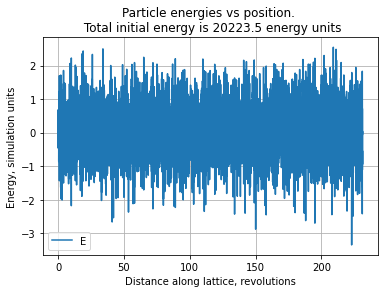

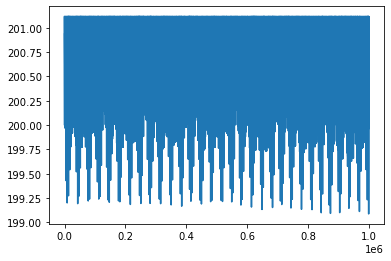

In [42]:
%matplotlib inline
# for particle in swarmTraced:
#     particle.plot_Energies()
swarmTraced.particles[0].plot_Energies(showOnlyTotalEnergy=True)
swarmTraced.particles[0].revolutions
p0Arr=swarmTraced.particles[0].p0Arr
plt.plot(p0Arr)
plt.show()

### Tune the lattice to get better results

In [29]:
import multiprocess as mp
from asyncDE import solve_Async
def cost(knobParams):
    optimizer.T=1.0
    swarmCost,floorPlanCost=optimizer.mode_Match_Cost(knobParams,False,True,rejectIllegalFloorPlan=False,
                                                  rejectUnstable=False,returnCostsSeperate=True)
    return np.sqrt(swarmCost**2+floorPlanCost)
# xArr=np.linspace(.5,1.5,20)
# coords=np.asarray(np.meshgrid(xArr,xArr)).T.reshape(-1,2)
#
# t=time.time()
# with mp.Pool() as pool:
#     vals=np.asarray(pool.map(cost,coords,chunksize=4))
# print(time.time()-t)
solve_Async(cost,optimizer.tuningBounds,60,tol=.01)

------ITERATIONS:  60
POPULATION VARIABILITY: [0.30167191 0.30101442 0.27934849 0.29434116]
BEST MEMBER BELOW
---population member---- 
DNA: array([0.80986759, 1.00567494, 0.03034935, 0.34526041])
cost: 0.8642099556954415
------ITERATIONS:  120
POPULATION VARIABILITY: [0.29450442 0.28782337 0.27741357 0.30973993]
BEST MEMBER BELOW
---population member---- 
DNA: array([1.27861759, 1.05524191, 0.01      , 0.18631567])
cost: 0.7929650418717087
------ITERATIONS:  180
POPULATION VARIABILITY: [0.2762154  0.27809407 0.21127625 0.32718524]
BEST MEMBER BELOW
---population member---- 
DNA: array([1.38891205, 0.95604256, 0.01      , 0.22912064])
cost: 0.7452784628412797
------ITERATIONS:  240
POPULATION VARIABILITY: [0.25412832 0.22834241 0.17150343 0.30918342]
BEST MEMBER BELOW
---population member---- 
DNA: array([0.96248673, 0.99844448, 0.05239434, 0.1997635 ])
cost: 0.6603849832978113
------ITERATIONS:  300
POPULATION VARIABILITY: [0.21243072 0.18547054 0.14472026 0.26355029]
BEST MEMBER BELO

Process ForkPoolWorker-1249:
Process ForkPoolWorker-1257:
Process ForkPoolWorker-1250:


KeyboardInterrupt: 

Process ForkPoolWorker-1252:
Process ForkPoolWorker-1254:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


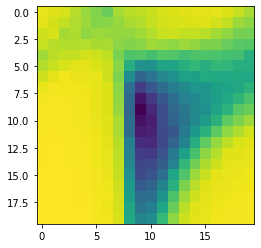

0.591839462973168

In [21]:
vals=np.asarray(vals)
image=vals.reshape(len(xArr),len(xArr))
plt.imshow(image)
plt.show()
np.min(image)

In [24]:
optimizer.tuningBounds

[(0.0, inf), (0.0, inf), (0.01, 0.4), (0.01, 0.4)]